# Australian Open 2019 - Mens Final 2019 Djokovic vs. Nadal
Nowadays, in most sports either tracking or event data is available for sports data scientists to analyse leagues, teams, games or players. For example, in soccer event-based data is available for all major leagues by professional data providers like [Opta](https://www.optasports.com/), [Statsbomb](https://statsbomb.com/) or [Wyscout](https://wyscout.com/). Generating event data for football matches is incredibly time consuming as there are lots of different events to annotate.  For tennis there is no event data available that covers the actual rallies played in games on either ATP or WTA tour. There exists official statistics of all matches played on ATP and WTA Tour. There is also Jeff Sackmans [github repository](https://github.com/JeffSackmann), which is a great way to start. He also has a [match charting project](http://www.tennisabstract.com/blog/2015/09/23/the-match-charting-project-quick-start-guide/) where point-by-point data is collected.
But when I think about tennis, it is the movement of the ball and players, the tactics and the actual rallies and strokes. This is what I want to be able to see and analyse.  
As a proof of concept that collecting detailed data about positional, temporal and stroke information in tennis is possible and as a tribute to Novac Djokovic and Rafael Nadal, two of the greatest tennis players of all time, I manually annotated each rally and stroke of their [Australian Open final 2019](https://www.atptour.com/en/scores/2019/580/MS001/match-stats?isLive=False). Fortunately for me it only went over three sets.
The results are a couple of csv files that can be easily analyzed using pandas or R.  
I prepared this notebook as a staring point for everyone who wants to work with rally-by-rally tennis data and I hope you enjoy it.

In [2]:
import os
import numpy as np
import pandas as pd

# Plotly and cufflinks for data analysis
from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf
init_notebook_mode(connected=True) 

cf.set_config_file(theme='ggplot')
cf.go_offline()

# Matplotlib for drawing the court
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline


ModuleNotFoundError: No module named 'plotly'

In [3]:
INPUT_DIR = '../input'
def load_data():
    return [pd.read_csv(os.path.join(INPUT_DIR, file_), index_col=0) for file_ in os.listdir(INPUT_DIR)]
        
serves, rallies, points, events = load_data()

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: '../input'

# The Data
The data consists of all points played in the match. It is build hierarchically from **events**, to **rallies**, to actual **points**.
- **Events**: Each time a player hit the ball, the stroke type, position of the player, and position of the opponent were recorded. 
- **Points**: a list of all points played in the final with information about the server, receiver, point type, number of strokes, time of rally, new score of the game. 
- **Rallies**: A list of all rallies with Server, Returner, etc. 
- **Serves**: For each successful serve, which was no failure, the position of the serve in the service box was recorded (whenever possible)

I have already done the hard part of data cleaning, and the dataset is hopefully easy to understand and ready to use.
The x,y coordinates for the players were mapped from pixel coordinates to real world coordinates employing a [Direct Linear Transform (DLT)](https://en.wikipedia.org/wiki/Direct_linear_transformation). It is not perfect because the camera perspective changed slightly during the match, but it worked reasonably well.

## Events

In [3]:
# events
events.head()

,rallyid,frameid,strokeid,hitter,receiver,isserve,serve,type,stroke,hitter_x,hitter_y,receiver_x,receiver_y,time
0,1,70877,1,Djokovic,Nadal,True,first,serve,forehand,6.50,-0.24,1.03,27.44,0.00
1,1,70900,2,Nadal,Djokovic,False,first,slice,backhand,0.05,25.59,6.17,1.11,0.92
2,1,70950,3,Djokovic,Nadal,False,first,topspin,forehand,1.42,2.33,4.75,26.45,2.92
3,2,71488,1,Djokovic,Nadal,True,first,serve,forehand,4.48,-0.01,7.90,26.83,24.44
4,3,71796,1,Djokovic,Nadal,True,second,serve,forehand,4.48,-0.37,7.88,26.47,36.76


This dataframe contains all labeled events from the tennis match. Each row relates to when one of the players hit the ball. The player who his the ball is called hitter and the other player receiver. A flag isserve describes if the shot was a serve or not. serve tells us if the stroke happened in a rally after a first or second serve. Type and stroke relate to the recognized stroke type, i.e. forehand topspin.
## Points

In [4]:
# points
points.head()

,rallyid,server,returner,winner,reason,serve,strokes,totaltime,x,y,score
0,1,Djokovic,Nadal,Djokovic,winner,first,3,0.92,1.92,21.96,"0:0, 15:0"
2,3,Djokovic,Nadal,Djokovic,out,second,4,4.16,3.33,-0.39,"0:0, 30:0"
4,5,Djokovic,Nadal,Djokovic,ace,second,2,0.40,1.62,17.18,"0:0, 40:0"
5,6,Djokovic,Nadal,Djokovic,net,first,10,10.40,6.41,12.78,"1:0, 0:0"
7,8,Nadal,Djokovic,Djokovic,out,second,7,7.20,0.50,18.67,"1:0, 15:0"


The dataframe contains data for all 142 points played in the match. Each point has a related rallyid and consists of the player who started the rally with his serve, the return player, the winner of the point, the number of strokes in the rally and the total time in seconds elapsed in the rally. The x,y coordinate describes the position on the court where the rally ended. For a winner it is where the ball bounced the first time, for a net ball it is the position in the net and for an out ball the position outside the court where the ball bounced the first time.
## Rallies

In [5]:
# rallies
rallies.head()

,rallyid,server,returner,winner,reason,serve,strokes,totaltime,x,y
0,1,Djokovic,Nadal,Djokovic,winner,first,3,0.92,1.92,21.96
1,2,Djokovic,Nadal,__undefined__,second_serve,first,1,0.00,7.42,12.10
2,3,Djokovic,Nadal,Djokovic,out,second,4,4.16,3.33,-0.39
3,4,Djokovic,Nadal,__undefined__,second_serve,first,1,0.00,4.64,17.69
4,5,Djokovic,Nadal,Djokovic,ace,second,2,0.40,1.62,17.18


This dataframe is similar to the data in points.csv but including all rallies, especially all serves that lead to a second serve which are encoded as rallies with only one stroke and an undefined winner.
## Serves

In [6]:
# serves
serves.head()

,rallyid,server,x,y
0,1,Djokovic,1.86,16.80
1,3,Djokovic,7.05,16.97
2,6,Djokovic,8.04,17.80
3,8,Nadal,4.44,16.24
4,9,Nadal,5.71,16.40


This dataframe contains the positions in the service box where successful serves bounced. Failed serves are not included. For some serves the actual position of the bounce could not be tracked due to changes in the perspective of the broadcast video. Due to a shift in perspective through the game most of the positions are shifted a little bit to the left. The distribution of serves of both players can still be seen reasonably well.

# General statistics
It is straight-forward to aggregate the rally results into general statistics of the match. Here are some examples
## Points won

In [7]:
points[['rallyid','winner']].groupby('winner').count()

,rallyid
winner,
Djokovic,89
Nadal,53


## Points won by serve

In [8]:
points.groupby(['winner','serve']).size().reset_index(name='counts')

,winner,serve,counts
0,Djokovic,first,62
1,Djokovic,second,27
2,Nadal,first,36
3,Nadal,second,17


## Points won by result
Each rally contains an encoding of the reason why a rally ended and the winner of the rally. The events `double_fault`, `net`, and `out` refer to a fault by the opponent of the winning player.

In [9]:
points.groupby('reason')['winner'].value_counts().unstack().iplot(kind='bar')

# Simple Plots
As this notebook is intended as starting point for own investigations, here are some sample plots that might be useful in your own investigations.

## Tennis court dimensions
Here is a function to draw the tennis court and its coordinate system. (The code is shown in the notebook.)

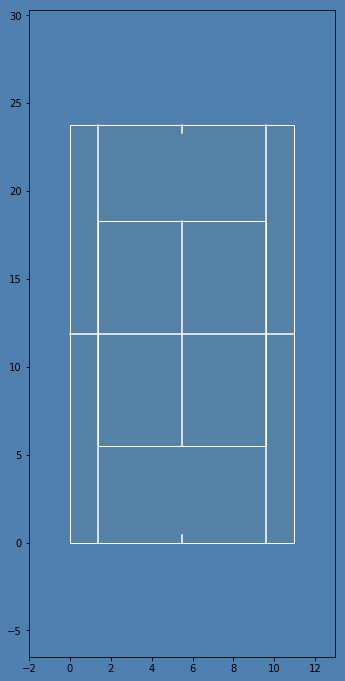

In [10]:

#### Tennis data

height_court = 10.97
width_court = 11.89*2
service_box = 6.4
double_field = 1.37
baseline_serviceline = 5.5
breite_einzel = 8.23
serviceline_net = 6.4


def draw_court(hide_axes=False):
    """Sets up field
    Returns matplotlib fig and axes objects.
    """
        
    fig = plt.figure(figsize=(height_court/2, width_court/2))
    #fig = plt.figure(figsize=(9, 9))
    fig.patch.set_facecolor('#5080B0')

    axes = fig.add_subplot(1, 1, 1, facecolor='#5080B0')

    if hide_axes:
        axes.xaxis.set_visible(False)
        axes.yaxis.set_visible(False)
        axes.axis('off')

    axes = draw_patches(axes)
    
    return fig, axes

def draw_patches(axes):
    plt.xlim([-2,height_court+2])
    plt.ylim([-6.5,width_court+6.5])
    
    #net
    axes.add_line(plt.Line2D([height_court, 0],[width_court/2, width_court/2],
                    c='w'))
    
    # court outline
    y = 0
    dy = width_court
    x = 0#height_court-double_field
    dx = height_court
    axes.add_patch(plt.Rectangle((x, y), dx, dy,
                       edgecolor="white", facecolor="#5581A6", alpha=1))
    # serving rect
    y = baseline_serviceline
    dy = serviceline_net*2
    x = 0 + double_field 
    dx = breite_einzel
    axes.add_patch(plt.Rectangle((x, y), dx, dy,
                       edgecolor="white", facecolor="none", alpha=1))
    
    #?
    #net
    axes.add_line(plt.Line2D([height_court/2, height_court/2], [width_court/2 - service_box, width_court/2 + service_box],
                    c='w'))
    
    axes.add_line(plt.Line2D([height_court/2, height_court/2], [0, 0 + 0.45], 
                    c='w'))

    axes.add_line(plt.Line2D([height_court/2, height_court/2], [width_court, width_court - 0.45], 
                c='w'))
    
    axes.add_line(plt.Line2D([1.37, 1.37], [0, width_court], 
            c='w'))
    
    axes.add_line(plt.Line2D( [height_court - 1.37, height_court - 1.37], [0, width_court],
        c='w'))

    return axes

fig, ax = draw_court();

## Tennis court with players
Of course a court alone is not enough, here is how you can add players to the court.

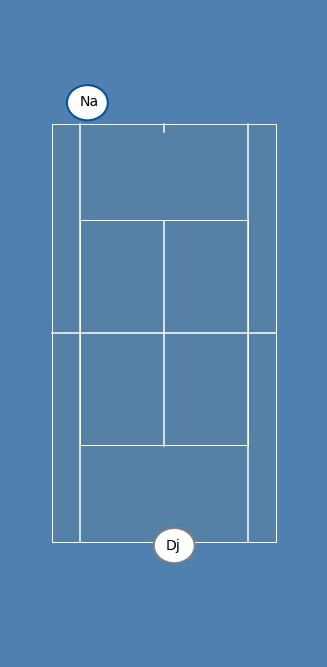

In [11]:
def draw_players(axes):
    colors = {'djokovic': 'gray',
              'nadal': '#00529F'}
    
    size = 2
    color='white'
    edge=colors['djokovic']                        
    
    axes.add_artist(Ellipse((6,
                             -0.2),
                              size,size,
                              edgecolor=edge,
                              linewidth=2,
                              facecolor=color,
                              alpha=1,
                              zorder=20))
    axes.text(6-0.4,-0.2-0.2,'Dj',fontsize=14, color='black', zorder=30)
                
    
    edge=colors['nadal']
    axes.add_artist(Ellipse((1.75,
                             25),
                              size,size, 
                              edgecolor=edge,
                              linewidth=2,
                              facecolor=color,
                              alpha=1,
                              zorder=20))
    axes.text(1.75-0.4,25-0.15,'Na',fontsize=14, color='black', zorder=30)
    
    return axes

fig, ax = draw_court(hide_axes=True);
ax = draw_players(ax)

# Advanced example
Using the data we can create replays of the rallies by linearly interpolating the positions of each player between two events. The result might look similar to this.
![Rally example](https://cdn-images-1.medium.com/max/1600/1*OHtO7fS1SEoGSiGEa1wSrg.gif)

# It is your turn
There is a ton you can do with this kind of data. Feel free to fork the kernel and extend and improve on the shown methods. Here are some possible topics to get you started.
* Generate a chart of the match statistics from the rally data
* Create a GUI that allows to easily replay points
* Investigate where both players served to. E.g. positions in service box, forehand or backhand of the opponent.
* Create heatmaps of the movement of each player for each set.
* Create a heatmap for each players return position.
* ...